In [1]:
"""author: Vetivert? 💐 
created: 30/05/2025 @ 04:02:42"""

'author: Vetivert? 💐 \ncreated: 30/05/2025 @ 04:02:42'

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.preprocessing import StandardScaler, label_binarize 
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, make_scorer 
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import randint, uniform 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
from src.utils.functions import *

# LOAD DATA

In [3]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': np.float64(56.4), '2': np.float64(39.66), '3': np.float64(3.94)}


/tmp/ipykernel_85487/1056633048.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('8(nặng xin về)', 8)
/tmp/ipykernel_85487/1056633048.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
/tmp/ipykernel_85487/1056633048.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [18]:
# df.drop(HEART_INDEX, axis=1, inplace=True)

df_set = df.loc[:, 'Gende':'Oliguria'].copy().fillna(0)
df_set = df_set.apply(pd.to_numeric, errors='coerce')

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set, df['Diagnosis'], \
                                                    test_size=0.2, random_state=14, stratify=df['Diagnosis'])
x1_features = x1_train.columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (324, 21) y1_train shape:  (324,)
x1_test shape:  (82, 21) y1_test shape:  (82,)
percentage of classes:  {'1': np.float64(56.1), '2': np.float64(43.9)}


In [19]:
model = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # helpful for imbalanced classes
)
model.fit(x1_train, y1_train)

y_pred = model.predict(x1_test)

print("Accuracy:", accuracy_score(y1_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y1_test, y_pred))
print("Classification Report:\n", classification_report(y1_test, y_pred))

Accuracy: 0.7682926829268293
Confusion Matrix:
 [[37  9]
 [10 26]]
Classification Report:
               precision    recall  f1-score   support

           1       0.79      0.80      0.80        46
           2       0.74      0.72      0.73        36

    accuracy                           0.77        82
   macro avg       0.77      0.76      0.76        82
weighted avg       0.77      0.77      0.77        82



In [24]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(x1_train, y1_train)
print("Best Params:", grid_search.best_params_)

Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


In [25]:
best_model = grid_search.best_estimator_
y_pred = model.predict(x1_test)

print("Accuracy:", accuracy_score(y1_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y1_test, y_pred))
print("Classification Report:\n", classification_report(y1_test, y_pred))

Accuracy: 0.7682926829268293
Confusion Matrix:
 [[37  9]
 [10 26]]
Classification Report:
               precision    recall  f1-score   support

           1       0.79      0.80      0.80        46
           2       0.74      0.72      0.73        36

    accuracy                           0.77        82
   macro avg       0.77      0.76      0.76        82
weighted avg       0.77      0.77      0.77        82



In [26]:
scores = cross_val_score(best_model, x1_train, y1_train, cv=5)
print("Cross-validation accuracy scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation accuracy scores: [0.78461538 0.67692308 0.76923077 0.67692308 0.78125   ]
Mean CV accuracy: 0.7377884615384616


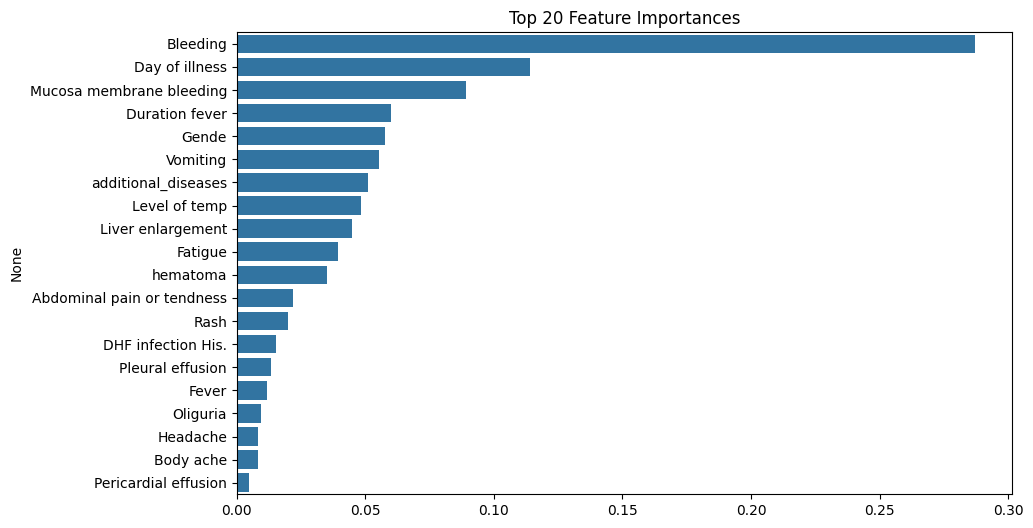

In [27]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:20], y=x1_train.columns[indices][:20])
plt.title("Top 20 Feature Importances")
plt.show()